In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import urllib.request

In [4]:
  # 创建一个字典用于存储config
MASTER_CONFIG = {
    # 参数放这里
}

In [5]:
url = "https://raw.githubusercontent.com/mc112611/PI-ka-pi/main/xiyouji.txt"
file_name = "xiyouji.txt"
urllib.request.urlretrieve(url, file_name)

('xiyouji.txt', <http.client.HTTPMessage at 0x7f058bc1ba10>)

In [6]:
#读数据
lines = open("/home/wk/ZeroHero/xiyouji.txt","r").read()

#创建简易版词表
vocab = sorted(list(set(lines)))
print(vocab)
#查看词表前n个字符
head_num = 50
print("词表前{}个".format(head_num),vocab[:head_num])

['\n', ' ', '!', '"', '#', '*', ',', '.', '—', '‘', '’', '“', '”', '□', '、', '。', '《', '》', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丑', '专', '且', '丕', '世', '丘', '丙', '业', '丛', '东', '丝', '丞', '丢', '两', '严', '丧', '个', '丫', '中', '丰', '串', '临', '丸', '丹', '为', '主', '丽', '举', '乃', '久', '么', '义', '之', '乌', '乍', '乎', '乏', '乐', '乒', '乓', '乔', '乖', '乘', '乙', '乜', '九', '乞', '也', '习', '乡', '书', '买', '乱', '乳', '乾', '了', '予', '争', '事', '二', '于', '亏', '云', '互', '五', '井', '亘', '亚', '些', '亡', '亢', '交', '亥', '亦', '产', '亨', '亩', '享', '京', '亭', '亮', '亲', '亵', '人', '亿', '什', '仁', '仃', '仅', '仆', '仇', '今', '介', '仍', '从', '仑', '仓', '仔', '他', '仗', '付', '仙', '仞', '代', '令', '以', '仪', '们', '仰', '仲', '仵', '件', '价', '任', '仿', '伉', '伊', '伍', '伏', '伐', '休', '众', '优', '伙', '会', '伞', '伟', '传', '伤', '伦', '伪', '伫', '伯', '估', '伴', '伶', '伸', '伺', '似', '伽', '佃', '但', '佈', '位', '低', '住', '佐', '佑', '体', '何', '余', '佚', '佛', '作', '佞', '你', '佣', '佥', '佩', '佯', '佳', '使', '侄', '侈', '例', '侍', '供', '依', '侠', '侣', '侥', '侧'

In [7]:
#将词表编码为数字，普通的整数
itos = {i:ch for i,ch in enumerate(vocab)}
stos = {ch:i for i,ch in enumerate(vocab)}

In [8]:
#编码器
def encode(s):
  return [stos[ch] for ch in s]

def decode(l):
  return ''.join([itos[i] for i in l])
decode(encode("猪八戒"))
encode("猪八戒")

[2365, 293, 1383]

In [9]:
#对全文进行编码，并映射为tensor
dataset = torch.tensor(encode(lines), dtype=torch.int16)
print(dataset.shape)
print(dataset)

torch.Size([658298])
tensor([   0, 4319, 1694,  ...,   12,    0,    0], dtype=torch.int16)


In [10]:
#构建batch
def get_batches(data,split,batch_size,context_window,config=MASTER_CONFIG):
  #切分训练集，验证集，测试集 0.8:0.1:0.1
  train = data[:int(0.8*len(data))]
  val = data[int(0.8*len(data)):int(0.9*len(data))]
  test = data[int(0.9*len(data))]
  #将全部的训练数据作为batch
  batch_data = train
  if split == 'val':
      batch_data = val
  if split == 'test':
        batch_data = test
  # 这里需要学习torch.randint，生成大小为batch_size，内部数值为随机整数的tensor。生成随机数数值域为[0,训练集字符数量-滑动窗口大小-1]之间的整数
  # 详情可以参考官方文档，或者这个博客：https://blog.csdn.net/qq_41813454/article/details/136326473
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
  # print('ix输出:')
  # print(ix)
  x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
  y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

  return x,y





In [11]:
# 根据上面构造的get_batchs()函数，更新参数字典。
MASTER_CONFIG.update({
    'batch_size': 8,          # 不解释
    'context_window': 16,      # 滑动窗口采样，设置采样大小
    'vocab_size':4325         # 咱们的西游记数据集，一共包含4325个不重复的汉字，标点符号
})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# 获取训练数据
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
# 因为是随机生成的采样，我们可以看一下数据，其中每个采样数据，来自于原文随机的起始点，每个元组为一个（x,y），可以观察每个x和y的首位去直观感受一下滑动窗口执行的操作
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

print(decoded_samples)

[('去了，有何难哉！”那\n老者笑道：', '了，有何难哉！”那\n老者笑道：“'), ('要运筹。\n捉牛耕地金钱长，唤豕归', '运筹。\n捉牛耕地金钱长，唤豕归炉'), ('已把门打破，\n杀进来也！”大圣怒', '把门打破，\n杀进来也！”大圣怒道'), ('去？”行者才说：“我是齐天\n大圣', '？”行者才说：“我是齐天\n大圣，'), ('道：“八戒，造化！抬\n出锅来，想', '：“八戒，造化！抬\n出锅来，想是'), ('，不须久停，快去快去！”\n好行者', '不须久停，快去快去！”\n好行者，'), ('头观看，只见第十三层塔心里坐着两', '观看，只见第十三层塔心里坐着两个'), ('道：“怎的断根？”行者道：“我们', '：“怎的断根？”行者道：“我们前')]


In [13]:
#构建一个评估函数
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
  #评估结果存储变量
  out = {}

  #将模型设置为评估模式
  model.eval()

  #分别在训练集和验证集里通过get_batched()函数得到评估数据
  for split in ["train","val"]:
    losses = []

    #评估10个batch
    for _ in range(10):
      #拿到特征值（输入数据），以及目标值（输出数据）
      xb,yb = get_batches(dataset,split,config['batch_size'],config['context_window'])
      xb, yb = xb.to(device), yb.to(device)
      
      _,loss = model(xb,yb)
      #更新得到的loss值
      losses.append(loss.item())
    out[split] = np.mean(losses)
  #评估结束以后需要把模型设置回训练状态,下一个batch使用
  model.train()

  return out


In [14]:
# 在进行分析LlaMa架构分析之前，我们从最简单的文本生成模型开始创建，然后在最简单的文本生成模型的基础上，把LlaMa的RSM，Rope等一点点添加进去。为此我们先：
# 创建一个有毛病的模型架构
class StupidModel(nn.Module):
  def __init__(self,config=MASTER_CONFIG):
     super().__init__()
     self.config = config

    # embedding层，输入：词表大小，输出：维度大小
     self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

     #创建线性层用来捕捉特征关系
     self.linear = nn.Sequential(
         nn.Linear(config["d_model"], config["d_model"]),
         nn.ReLU(),
         nn.Linear(config['d_model'],config['vocab_size']),

     )
     print("模型参数量：", sum([m.numel() for m in self.parameters()]))






In [15]:
#给模型加上前向传播
class SimpleBrokenModel(nn.Module):
  def __init__(self,config=MASTER_CONFIG):
     super().__init__()
     self.config = config

    # embedding层，输入：词表大小，输出：维度大小
     self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

     #创建线性层用来捕捉特征关系
     self.linear = nn.Sequential(
         nn.Linear(config["d_model"], config["d_model"]),
         nn.ReLU(),
         nn.Linear(config['d_model'],config['vocab_size']),

     )
     print("模型参数量：", sum([m.numel() for m in self.parameters()]))

  def forward(self,idx,targets=None):
    # 实例化embedding层，输入映射为id的数据，输出embedding后的结果
    x = self.embedding(idx)

    #线性层承接embedding层输出的数据
    a = self.linear(x)
    #对线性层在最后一个维度的数据进行softmax，得到概率分布
    logits = F.softmax(a,dim=-1)

    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,self.config['vocab_size']),targets.view(-1))
      return logits, loss
     # 如果没有目标值，则只返回概率分布的结果
    else:
      return logits

    # 查看参数量
    print("模型参数量：", sum([m.numel() for m in self.parameters()]))

In [16]:
# 这里我们设置这个模型为128维的embedding
MASTER_CONFIG.update({
    'd_model': 128,
})

# 实例化模型，传参
model = SimpleBrokenModel(MASTER_CONFIG)

# 再看看参数量
print("咱们的模型这么多参数量:", sum([m.numel() for m in model.parameters()]))
# 于是乎，我们创建了一个1128307个参数的模型，上面参数想怎么改，自己改！电脑不会爆炸！

模型参数量： 1128037
咱们的模型这么多参数量: 1128037


In [17]:
# 获取训练的特征数据与目标数据
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# 扔进模型获取概率分布矩阵与loss
logits, loss = model(xs, ys)



In [18]:
#更新参数，训练轮次，batch_size，log日志打印步长
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,      # 每10个batch打印一次log
    'batch_size': 32,
})

# 实例化模型
model = SimpleBrokenModel(MASTER_CONFIG)


# 创建一个Adam优化器，基础知识，
optimizer = torch.optim.Adam(
    model.parameters(),      # 优化器执行优化全部的模型参数
)
# 设置 cosine 学习率
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

模型参数量： 1128037


Epoch 0 | val loss 8.372 | Time 0.384 | ETA in seconds 38.365
lr:  [0.0009999950652079463]
Epoch 10 | val loss 8.372 | Time 0.017 | ETA in seconds 1.661
lr:  [0.0009996496708566316]
Epoch 20 | val loss 8.371 | Time 0.014 | ETA in seconds 1.403
lr:  [0.0009988111874732917]
Epoch 30 | val loss 8.356 | Time 0.015 | ETA in seconds 1.479
lr:  [0.000997480442539433]
Epoch 40 | val loss 8.344 | Time 0.016 | ETA in seconds 1.565
lr:  [0.000995658749339282]
Epoch 50 | val loss 8.322 | Time 0.016 | ETA in seconds 1.488
lr:  [0.0009933479056637284]
Epoch 60 | val loss 8.313 | Time 0.018 | ETA in seconds 1.727
lr:  [0.0009905501920361237]


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 70 | val loss 8.296 | Time 0.017 | ETA in seconds 1.570
lr:  [0.000987268369461681]
Epoch 80 | val loss 8.280 | Time 0.017 | ETA in seconds 1.528
lr:  [0.0009835056767026945]
Epoch 90 | val loss 8.267 | Time 0.016 | ETA in seconds 1.452
lr:  [0.00097926582708227]
Epoch 100 | val loss 8.255 | Time 0.015 | ETA in seconds 1.351
lr:  [0.0009745530048197264]
Epoch 110 | val loss 8.242 | Time 0.016 | ETA in seconds 1.381
lr:  [0.0009693718609012748]
Epoch 120 | val loss 8.247 | Time 0.016 | ETA in seconds 1.432
lr:  [0.000963727508490054]
Epoch 130 | val loss 8.238 | Time 0.016 | ETA in seconds 1.397
lr:  [0.0009576255178800583]
Epoch 140 | val loss 8.239 | Time 0.016 | ETA in seconds 1.348
lr:  [0.0009510719109989285]
Epoch 150 | val loss 8.239 | Time 0.017 | ETA in seconds 1.469
lr:  [0.0009440731554650348]
Epoch 160 | val loss 8.230 | Time 0.015 | ETA in seconds 1.300
lr:  [0.0009366361582047184]
Epoch 170 | val loss 8.227 | Time 0.017 | ETA in seconds 1.393
lr:  [0.0009287682586359

<Axes: >

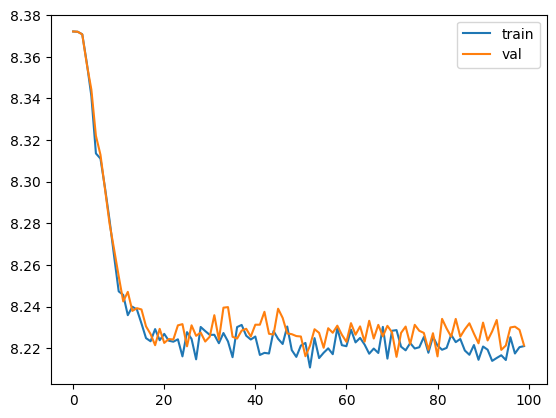

In [19]:
# 构建训练函数
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    
    # 将模型移到指定设备
    model.to(device)
    
    # loss存储
    losses = []

    # 训练时间记录开始时间
    start_time = time.time()

    # 循环训练指定epoch的轮数
    for epoch in range(config['epochs']):
        # 优化器要初始化啊，否则每次训练都是基于上一次训练结果进行优化，效果甚微
        optimizer.zero_grad()

        # 获取训练数据
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        xs, ys = xs.to(device), ys.to(device)  # 确保数据也在相同的设备上
        
        logits, loss = model(xs, targets=ys)

        # 反向传播更新权重参数，更新学习率优化器
        loss.backward()
        optimizer.step()

        # 如果提供学习率调度器，那么学习率会通过调度器进行修改，比如学习率周期性变化，或者梯度减小，增加，具体策略需要综合考虑进行设置，详情自行查询，关键字：lr_scheduler
        if scheduler:
            scheduler.step()

        # 打印log
        if epoch % config['log_interval'] == 0:
            # 训练时间
            batch_time = time.time() - start_time

            # 执行评估函数，在训练集和验证集上计算loss
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # 打印进度日志
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # 重置开始时间，用于计算下一轮的训练时间
            start_time = time.time()

            # 打印下一轮的学习率，如果使用了lr_scheduler
            if scheduler:
                print("lr: ", scheduler.get_lr())
            

    # 上面所有epoch训练结束，打印最终的结果
    print("Validation loss: ", losses[-1]['val'])

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': losses[-1]['val'],
    }
    # 保存每个epoch的模型
    torch.save(checkpoint, f'/home/wk/ZeroHero/checkpoints/model_epoch_{epoch}.pt')

    # 返还每一步loss值的列表，因为我们要画图，返还的是loss迭代的图像
    return pd.DataFrame(losses).plot()

# 启动训练
train(model, optimizer,scheduler,MASTER_CONFIG,True)

In [20]:
# 拿掉softmax，logits改为获取最后一个线性层输出的结果，不进行softmax计算概率分布。
# 因此将这个架构取名为：不那么蠢的模型架构
class SimpleNotStupidModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
      super().__init__()
      self.config = config
      self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
      self.linear = nn.Sequential(
          nn.Linear(config['d_model'], config['d_model']),
          nn.ReLU(),
          nn.Linear(config['d_model'], config['vocab_size']),
      )
      print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # 看这里，线性层直接输出结果，不转换为概率矩阵，只修改这里，其余不动。
        logits = self.linear(x)
        # print(logits.shape)

        if targets is not None:

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Model parameters: 1128037
lr:  [4.934798141786878e-09]
lr:  [3.61210006324372e-07]
lr:  [1.1991810803429862e-06]
lr:  [2.529757769165489e-06]
lr:  [4.351367197909969e-06]
lr:  [6.662160644409954e-06]


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [9.459840745211405e-06]
lr:  [1.2741639311409557e-05]
lr:  [1.65043139998123e-05]
lr:  [2.074414950221495e-05]
lr:  [2.5456960410143068e-05]
lr:  [3.0638094981569465e-05]
lr:  [3.6282439549946715e-05]
lr:  [4.23844234730157e-05]
lr:  [4.893802457450767e-05]
lr:  [5.5936775053790876e-05]
lr:  [6.33737678478556e-05]
lr:  [7.124166343418859e-05]
lr:  [7.953269706494203e-05]
lr:  [8.823868642360539e-05]
lr:  [9.735103969561952e-05]
lr:  [0.0001068607640443545]
lr:  [0.0001167584744836897]
lr:  [0.00012703440313818878]
lr:  [0.00013767840888155252]
lr:  [0.00014867998734373127]
lr:  [0.0001600282812767295]
lr:  [0.00017171209126882325]
lr:  [0.00018371988679657448]
lr:  [0.000196039817603707]
lr:  [0.00020865972539558717]
lr:  [0.000221567155837762]
lr:  [0.00023474937084668967]
lr:  [0.0002481933611605374]
lr:  [0.000261885859177626]
lr:  [0.0002758133520498341]
lr:  [0.000289962095018069]
lr:  [0.0003043181249766013]
lr:  [0.0003188672742529062]
lr:  [0.0003335951845893904]
lr:  [0.0

<Axes: >

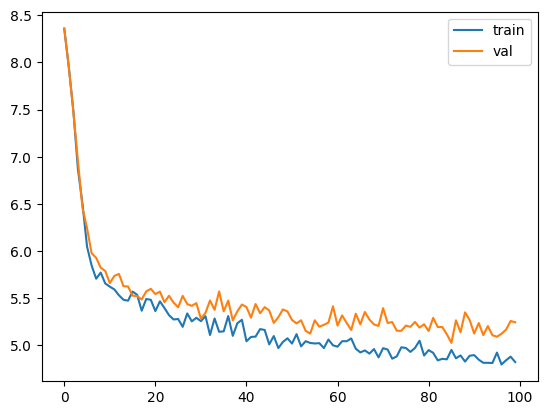

In [21]:
# 再来一次实例化各种功能，再启动一次训练
model = SimpleNotStupidModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer,scheduler)

# loss开窍了，下降了很多

In [22]:
# 推理函数（输出结果就别纠结其效果了，权重都没保存，就是根据模型初始化生成的随机数组成的矩阵做的推理）
def generate(model, config=MASTER_CONFIG, max_new_tokens=20):
    # 生成随机数，作为输入数据,5行一列，代表输入5个字符。 这个地方可以自行替换其他随机数测试。
    idx = torch.zeros(5, 1).long()
    idx = idx.to(device)  # 确保idx在正确的设备上
    print(idx[:, -config['context_window']:])
    for _ in range(max_new_tokens):
        # 因为推理的时候，依赖后面的n个token，所以滑动窗口要从后往前选择输入数据的倒数几个token，这个是超过字符数量会对输入进行截断，只选取最后几个token：idx[:, -config['context_window']:]
        logits = model(idx[:, -config['context_window']:])
        # print(logits.size())
        # 得到模型输出的结果，进行解码，这里logits[:, -1, :]挺抽象的，实际上第一维度是输入的字符数，第二维度是时间步，第三维度是词表
        # 即，对每一步的解码结果，取最后一个时间步的数据，作为输出的数据。解码的过程是第一次解码，输入5个token，第二次解码依赖的是原来5个token的最后4个，加上上一步解码生成的一个，也是5个token，如此循环。
        last_time_step_logits = logits[:, -1, :]
        # print('last_time_step_logits')
        # print(last_time_step_logits.shape)
        # 计算概率分布
        p = F.softmax(last_time_step_logits, dim=-1)
        # print('p_shape')
        # print(p.shape)
        # 根据概率分布计算下一个token，这里使用 torch.multinomial做的是随机采样
        idx_next = torch.multinomial(p, num_samples=1)
        # print('idx_next_shape')
        # print(idx_next.shape)
        # 将新的idx通过张量拼接写入到解码序列中
        idx = torch.cat([idx, idx_next], dim=-1)
    # 使用之前定义的解码函数，将ID转换为汉字，我们得到的5行21列的数据，来源于每一个输入字符作为开始位置，生成20个字符。 因为5个输入都是0，在词表中编号为0的数据是'\n'。
    print(idx.shape)
    return [decode(x) for x in idx.tolist()]

generate(model)


tensor([[0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
torch.Size([5, 21])


['\n换关洞喷手，六载张。行报方便为来说为磬缠',
 '\n听得那展，正，快禁了\n老\n办得二火之先倚',
 '\n魔王之道：“哥了他叫道：“且我把他去化时',
 '\n\n吆原来。那厮，我一把这钯丑人\n了？”噫',
 '\n就等矣时，\n三藏之接大路尘埃讲耳门，炼筋']

In [23]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # torch中register_parameter()功能为：向我们建立的网络module添加parameter
        # 因此，我们需要对pytorch官方封装好的RMSNorm功能模块添加一个可以训练参数的层，命名为scale，并初始化为形状为layer_shape，所有值为1的张量矩阵。
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        # 计算Frobenius范数（球某个矩阵中所有元素的平方和再开方得到，该范数用来衡量矩阵的大小，详情请百度）, RMS = 1/sqrt(N) * Frobenius
        # 具体来说，torch.linalg.norm(x, dim=(1, 2))计算了x在第1和第2维度上的范数。然后，将结果乘以x[0].numel() ** -.5。x[0].numel()表示x第一个元素（即x的第一行）的元素个数，** -.5表示求平方根的倒数。
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        # print(ff_rms.shape)
        # 将ff_rms算子应用于输入的张量x，依据公式，做除法，因为输入向量x是三维的，因此需要对ff_rms进行升两维，也变成三维的张量。这样可以进行元素之间的计算。
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        # print(raw.shape)
        # 返回scale缩放后归一化的张量
        # print(self.scale[:x.shape[1], :].unsqueeze(0) * raw)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [24]:
class SimpleNotStupidModel_RMS(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
      super().__init__()
      self.config = config
      self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
      # 在这里，我们添加RMS层
      self.rms = RMSNorm((config['context_window'], config['d_model']))
      self.linear = nn.Sequential(
          nn.Linear(config['d_model'], config['d_model']),
          nn.ReLU(),
          nn.Linear(config['d_model'], config['vocab_size']),
      )
      print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        # 在这里，添加实例化后的RMS层，承接Embedding层输出的张量
        x = self.rms(x)

        logits = self.linear(x)
        # print(logits.shape)

        if targets is not None:

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Model parameters: 1130085
lr:  [0.0009999950652079476]
lr:  [0.0009996496708566329]
lr:  [0.000998811187473293]
lr:  [0.0009974804425394344]


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [0.0009956587493392835]
lr:  [0.0009933479056637299]
lr:  [0.0009905501920361257]
lr:  [0.0009872683694616825]
lr:  [0.0009835056767026956]
lr:  [0.0009792658270822714]
lr:  [0.0009745530048197282]
lr:  [0.0009693718609012764]
lr:  [0.0009637275084900557]
lr:  [0.0009576255178800597]
lr:  [0.0009510719109989299]
lr:  [0.0009440731554650355]
lr:  [0.00093663615820472]
lr:  [0.0009287682586359918]
lr:  [0.0009204772214254094]
lr:  [0.0009117712288252914]
lr:  [0.0009026588725988193]
lr:  [0.0008931491455410033]
lr:  [0.0008832514326038829]
lr:  [0.0008729755016347048]
lr:  [0.0008623314937362442]
lr:  [0.0008513299132587526]
lr:  [0.0008399816174334365]
lr:  [0.0008282978056576788]
lr:  [0.0008162900084425839]
lr:  [0.0008039700760337515]
lr:  [0.0007913501667165227]
lr:  [0.00077844273481721]
lr:  [0.0007652605184121831]
lr:  [0.0007518165267569268]
lr:  [0.0007381240274474688]
lr:  [0.0007241965333268682]
lr:  [0.0007100477891496671]
lr:  [0.0006956917580174723]
lr:  [0.0006811426

<Axes: >

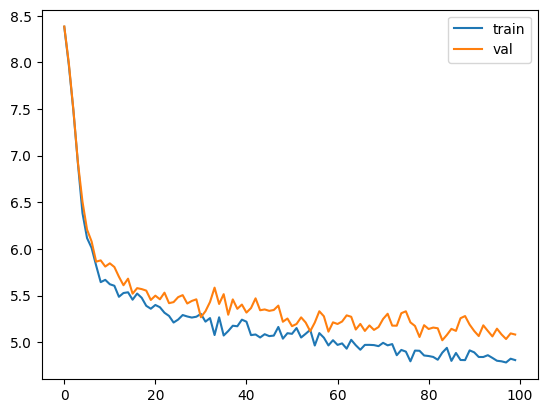

In [25]:
# 好啦，这样我们对原来的NotStupidModel添加了RMSNorm，现在执行一下看看
model = SimpleNotStupidModel_RMS(MASTER_CONFIG)

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer,scheduler)

# 在同样的训练超参数设置上，加入了RMSNorm的训练速度明显加快。

In [26]:
def get_rotary_matrix(context_window, embedding_dim):
    # 初始化一个0填充，形状为（context_window, embedding_dim, embedding_dim）的张量矩阵，其中context_window为token数量，后面两个embedding_dim组成正方形矩阵，与后面的attention计算对齐格式
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # 遍历每一个位置的token
    for position in range(context_window):
        # 还记得我的上一篇文章中说的，对于特征，两两组合吗，因此需要循环的次数为embedding_dim除以2
        for i in range(embedding_dim // 2):
            # 设置θ值，采样频率，或者说旋转频率，旋转角都可以，除以embedding_dim防止梯度问题。
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # 根据欧拉公式，计算旋转的角度，分别有sin 和cos，将计算拉到复数空间，并将旋转角度应用在上面的0填充的矩阵
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
            # 得到的结果是旋转位置编码矩阵，到这里还没覆盖到attention
    return R

In [41]:
# 此为单头注意力机制
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # 计算Q权重矩阵
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 计算K权重矩阵
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 计算V权重矩阵
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 获得旋转位置编码矩阵，接下来会覆盖Q和K权重矩阵
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])
        


    # 这里将上一个代码块中实现的创建旋转位置编码的功能函数原封不动的拿过来
    def get_rotary_matrix(context_window, embedding_dim):
        # 初始化一个0填充，形状为（context_window, embedding_dim, embedding_dim）的张量矩阵，其中context_window为token数量，后面两个embedding_dim组成正方形矩阵，与后面的attention计算对齐格式
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        # 遍历每一个位置的token
        for position in range(context_window):
            # 还记得我的上一篇文章中说的，对于特征，两两组合吗，因此需要循环的次数为embedding_dim除以2
            for i in range(embedding_dim // 2):
                # 设置θ值，采样频率，或者说旋转频率，旋转角都可以，除以embedding_dim防止梯度问题。
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # 根据欧拉公式，计算旋转的角度，分别有sin 和cos，将计算拉到复数空间，并将旋转角度应用在上面的0填充的矩阵
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
                # 得到的结果是旋转位置编码矩阵，到这里还没覆盖到attention
        return R

    def forward(self, x, return_attn_weights=False):
        # 前向传播时，输入矩阵的形状为(batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # 线性变换Q,K,V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        self.R = self.R.to(device)
        # 将旋转位置编码应用于Q和K，其中torch.bmm为矩阵做外积，transpose是转置，对Q矩阵转置，并与旋转位置编码做外积，再转置回原状，Q便应用了旋转位置编码。
        # 考虑到输入文本的长度，因此对位置编码矩阵在第一维度做截断，因为长了也没用，与文本长度一样。
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        # 同理对K也应用旋转位置编码进行覆盖
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # 对注意力机制点积进行等比例缩放，防止attention张量过长引发梯度爆炸，对应
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )
        # 如果return_attn_weights参数置为1，则需要对attention进行掩码，因为在学习的时候，希望模型能依据前n个token去预测token，而不是开卷考试。
        if return_attn_weights:
            # 创建注意力掩码矩阵，其中torch.tril函数为：对于矩阵，取左下三角，剩下的都置0
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # 计算注意力机制的权重矩阵，并对最后一维度做归一化，（突击检查）为什么是最后一维！因为最后一维度是每个token的特征向量！
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

In [42]:
# 多头注意力机制
class RoPEMaskedMultiheadAttention(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.config = config
    self.heads = nn.ModuleList([
        RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
    ])
    # 在模型结构上，创建一个线性层（隐藏层），用于线型输出注意力机制头输出的张量矩阵，寻找多头之间的特征，但是更主要的是，x经过多头计算后形状改变了，创建线性层，让张量矩阵变回原来输入的形状。
    # 同时为了防止过拟合，使用随机神经元失活，比率0.1
    # 线性层输入形状：注意力机制的头数，乘以矩阵的维度，关联到俺的上一篇文章，就是key矩阵，在多头之间共享权重，减少计算的思维。 输出为：模型的embedding维度数
    self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
          # 输入矩阵形状x： (batch, sequence length, dimension)

          # 每一个注意力机制头，都传入X进行计算。（这个地方开启并行执行会不会快一些，但是不知道pytorch是不是自动调用并行）
          heads = [h(x) for h in self.heads]
          # 输入张量x经过多个头计算attention（同时，attention是已经覆盖了RoPE的），重新拼接成新的矩阵，重新放入变量x。到这里你应该觉得：那矩阵形状不就变了吗
          x = torch.cat(heads, dim=-1)

          # 这不，线性层的作用来了
          x = self.linear(x)

          # 随机失活一下，防止过拟合
          x = self.dropout(x)
          return x


In [43]:
# Llama 32个注意力机制头，我们来8个吧

MASTER_CONFIG.update({
    'n_heads': 8,
})

In [45]:
# 我们已经创建完了所需要的算子，  现在积木已创建完毕，将这些积木组合起来！！！！
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding层
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm层
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # 旋转位置编码器+注意力机制
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # 线性层+激活函数变为非线性输出！
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        # 最终的输出，因为需要解码，因为输出的维度与词表大小统一！！！
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))
    # 前向传播
    def forward(self, idx, targets=None):
        # embedding，不解释
        x = self.embedding(idx)
        # 归一化数值，不解释
        x = self.rms(x)
       
        # 相加，解释一下，因为attention是要覆盖到原矩阵的，想象两个形状一样的矩阵为两张纸，左手一张纸，右手一张纸，双手合十，啪！覆盖。 使用加算，就是将两个矩阵中的元素按位置相加！直接覆盖值！
        x = x + self.rope_attention(x)
        
        # 再归一化！
        x = self.rms(x)
        # 因为直接计算归一化的数值可能出现梯度问题，因此把归一化的值作为修正系数，再覆盖！
        x = x + self.linear(x)
        # 到这里，才是最终输出vocab数量的神经元输出！！！！！！
        logits = self.last_linear(x)

        # 训练阶段有目标值
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        # 验证或者推理阶段，目标值y没有！只有结果，没有loss！
        else:
            return logits

model params: 1654501
Model is on device: cuda:0
data is on device: cuda:0
lr:  [4.934798141786878e-09]
lr:  [3.61210006324372e-07]


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [1.199181080342986e-06]
lr:  [2.529757769165308e-06]
lr:  [4.351367197910026e-06]
lr:  [6.662160644410011e-06]
lr:  [9.459840745211694e-06]
lr:  [1.2741639311409829e-05]
lr:  [1.65043139998121e-05]
lr:  [2.0744149502214878e-05]
lr:  [2.545696041014294e-05]
lr:  [3.0638094981569234e-05]
lr:  [3.6282439549946356e-05]
lr:  [4.2384423473015456e-05]
lr:  [4.8938024574507114e-05]
lr:  [5.593677505379088e-05]
lr:  [6.337376784785583e-05]
lr:  [7.124166343418909e-05]
lr:  [7.953269706494243e-05]
lr:  [8.82386864236052e-05]
lr:  [9.73510396956205e-05]
lr:  [0.0001068607640443543]
lr:  [0.00011675847448368954]
lr:  [0.00012703440313818832]
lr:  [0.00013767840888155222]
lr:  [0.00014867998734373035]
lr:  [0.00016002828127672955]
lr:  [0.00017171209126882315]
lr:  [0.0001837198867965746]
lr:  [0.0001960398176037075]
lr:  [0.00020865972539558703]
lr:  [0.00022156715583776252]
lr:  [0.00023474937084669013]
lr:  [0.00024819336116053763]
lr:  [0.00026188585917762553]
lr:  [0.00027581335204983283]

<Axes: >

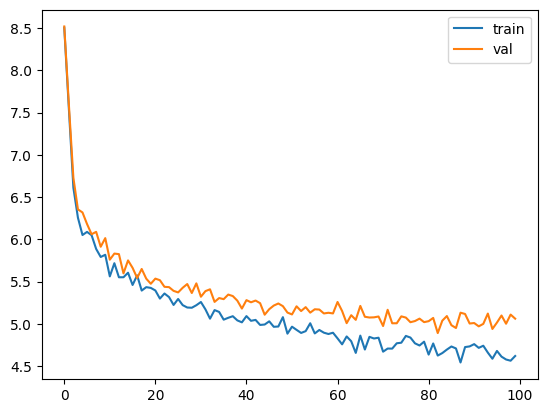

In [46]:
# 再跑一下！
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)
model = model.to(device)
print("Model is on device:", next(model.parameters()).device)
print("data is on device:", xs.device)
logits, loss = model(xs, ys)
# 查看模型所在的设备

optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer,scheduler)
# loss下降了百分之0.1！

In [47]:
class SwiGLU(nn.Module):

    def __init__(self, size):
        super().__init__()
        # 定义一个门控的线性层，输入输出都是门控结构的尺寸
        self.linear_gate = nn.Linear(size, size)
        # 门控结构主干线性层
        self.linear = nn.Linear(size, size)
        # 初始化一个随机数作为beta系数
        self.beta = torch.randn(1, requires_grad=True)

        # nn.Parameter用于指定某一层参数为可学习的，即本来不能通过训练更改参数，现在变成了可以经过训练来更新的参数。
        self.beta = nn.Parameter(torch.ones(1))
        # 将随机数beta指定为一个名为beta的神经网络层
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish门控但愿的计算：（从括号里开始）对于原始输入的数据张量，经过线性变换乘以beta系数，再经过sigmoid变换为0-1之间的值，再乘以原数据经过门控线性变换。总的来说，线型输出经过非线性变换，再应用到线性变换的结果，元素按位置相乘，修正原本数据张量，就是这个门控结构做的事情。
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        # 将门控结构输出的值再按位乘以线型输出的原数据张量
        # 为啥这么做，我不知道，但是论文复现的代码就是这样滴，有兴趣可以研究一下，我没研究过。
        out = swish_gate * self.linear(x)
        return out

In [48]:
# 再将swiglu添加进上面的模型
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            # 在这里，增加了SwiGLU层
            SwiGLU(config['d_model']),
        )
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        x = x + self.rope_attention(x)
        x = self.rms(x)
        x = x + self.linear(x)
        logits = self.last_linear(x)

        if targets is not None:
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 1687526
lr:  [0.0009999950652079491]
lr:  [0.0009996496708566344]


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [0.000998811187473294]
lr:  [0.000997480442539436]
lr:  [0.0009956587493392848]
lr:  [0.000993347905663731]
lr:  [0.0009905501920361266]
lr:  [0.000987268369461684]
lr:  [0.000983505676702697]
lr:  [0.000979265827082273]
lr:  [0.0009745530048197299]
lr:  [0.0009693718609012781]
lr:  [0.0009637275084900574]
lr:  [0.0009576255178800609]
lr:  [0.000951071910998931]
lr:  [0.0009440731554650371]
lr:  [0.0009366361582047208]
lr:  [0.0009287682586359939]
lr:  [0.0009204772214254106]
lr:  [0.0009117712288252932]
lr:  [0.0009026588725988204]
lr:  [0.0008931491455410052]
lr:  [0.000883251432603884]
lr:  [0.000872975501634707]
lr:  [0.000862331493736245]
lr:  [0.000851329913258753]
lr:  [0.0008399816174334378]
lr:  [0.00082829780565768]
lr:  [0.0008162900084425842]
lr:  [0.0008039700760337527]
lr:  [0.000791350166716524]
lr:  [0.000778442734817211]
lr:  [0.0007652605184121851]
lr:  [0.0007518165267569284]
lr:  [0.0007381240274474714]
lr:  [0.0007241965333268692]
lr:  [0.0007100477891496676]


<Axes: >

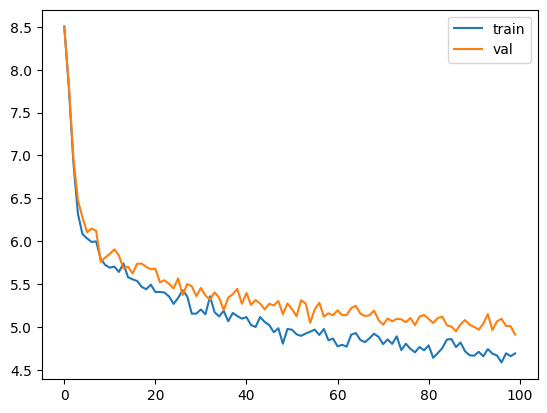

In [52]:
# 一二三四！再来一次！
model = RopeModel(MASTER_CONFIG)
model = model.to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs,ys = xs.to(device),ys.to(device)
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer,scheduler)

In [53]:
# OK！ 现在我们更新一下，隐藏层维度堆叠多少层，我们先来4层尝尝咸淡！！！！
MASTER_CONFIG.update({
    'n_layers': 4,
})

In [54]:
# 现在我们拥有了所有的算子，RMS，ROPE,SWIGLU，我们搭建我们的LlaMa！ 首先实现LlaMa的功能块，然后堆叠。
# 功能没什么好讲的，如果仔细看到了这里，下面的每一行代码都难不住你。
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):

        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [55]:
# 看一下我们的超参数字典
MASTER_CONFIG

{'batch_size': 32,
 'context_window': 16,
 'vocab_size': 4325,
 'd_model': 128,
 'epochs': 1000,
 'log_interval': 10,
 'n_heads': 8,
 'n_layers': 4}

In [58]:
# 用config字典，创建llama的功能块
block = LlamaBlock(MASTER_CONFIG)
block = block.to(device)

# 生成一条随机数据，丢到这个llama功能块里，看一下是不是有bug
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])
random_input = random_input.to(device)
# 执行以下看看输出
output = block(random_input)
output.shape

torch.Size([32, 16, 128])

In [60]:
# 现在，我们组装LlaMa
from collections import OrderedDict
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding不解释
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # 根据传入的堆叠层数，创建Llama功能块，注意OrderedDict为一种特殊类型的字典数据，保留字典写入的顺序，先插入的数据在前，后插入的数据在后。
        # 这里，我们将llama的功能块堆叠4层
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # FFN层，包含：线性层、激活函数非线性变换、再用线性层输出最终解码数值。
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # 看看咱们的大模型多少参数！
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # embedding嵌入
        x = self.embeddings(idx)
        # Llama模型计算
        x = self.llama_blocks(x)
        # FFN计算，得到logits
        logits = self.ffn(x)

        # 推理阶段没有目标值，只输出结果
        if targets is None:
            return logits
        # 训练阶段，有目标值，需要输出结果，以及loss，用于反向传播更新权重！
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 3465066


/home/wk/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [4.934798141786878e-09]
lr:  [3.61210006324372e-07]
lr:  [1.1991810803430541e-06]
lr:  [2.5297577691654348e-06]
lr:  [4.351367197909792e-06]
lr:  [6.662160644410011e-06]
lr:  [9.459840745211396e-06]
lr:  [1.2741639311409534e-05]
lr:  [1.6504313999812144e-05]
lr:  [2.0744149502215142e-05]
lr:  [2.545696041014257e-05]
lr:  [3.063809498156983e-05]
lr:  [3.628243954994592e-05]
lr:  [4.238442347301614e-05]
lr:  [4.893802457450697e-05]
lr:  [5.593677505379112e-05]
lr:  [6.337376784785662e-05]
lr:  [7.1241663434189e-05]
lr:  [7.95326970649408e-05]
lr:  [8.823868642360557e-05]
lr:  [9.73510396956181e-05]
lr:  [0.0001068607640443535]
lr:  [0.00011675847448368816]
lr:  [0.00012703440313818732]
lr:  [0.00013767840888155304]
lr:  [0.0001486799873437325]
lr:  [0.00016002828127672993]
lr:  [0.0001717120912688253]
lr:  [0.0001837198867965747]
lr:  [0.00019603981760370762]
lr:  [0.00020865972539558562]
lr:  [0.00022156715583775886]
lr:  [0.0002347493708466872]
lr:  [0.0002481933611605351]
lr:  [0

<Axes: >

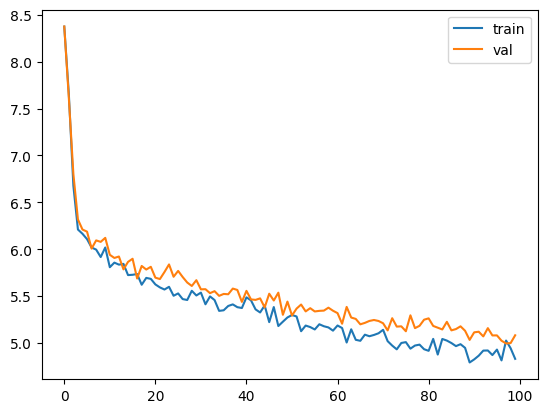

In [62]:
# 开始训练咱们的Llama
llama = Llama(MASTER_CONFIG)
llama = llama.to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs,ys = xs.to(device),ys.to(device)
logits, loss = llama(xs, ys)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer,scheduler)